# Practicum 7: Clustering

## Task 2: Implementing Bisecting K-Means clustering

  - Solve the previous task using the bisecting variant of K-Means
  - Measure the quality of the resulting clustering in terms of Sum of Squared Error (SSE)
    * How does it compare to the SSE using regular K-Means?   
    * How does it compare to the SSE of the 'true' clustering?

In [1]:
%matplotlib inline

In [2]:
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

Compute Eucledian distance between two points given as vectors (lists)

In [3]:
def dist(p1, p2):
    s = 0
    for i in range(len(p1)):
        s += math.pow(p1[i] - p2[i], 2)
    return math.sqrt(s)

Compute Sum of Squared Error (SSE) for each cluster

$\mathrm{SSE}=\sum_{i=1}^K\sum_{x \in C_i} dist(c_i,x)^2$

where 
  - $x$ is a data point
  - $K$ the number of clusters
  - $C_i$ is the ith cluster
  - $c_i$ is the centroid of cluster $C_i$

In [4]:
def sse(points, clusters, centroids):
    sse = [0] * (max(clusters) + 1)
    for idx, c in enumerate(clusters):
        sse[c] += dist(points[idx], centroids[c])
    return sse

Compute the distances of data points to the cluster centroids and assign to point to the cluster with the closest centroid.
(This method returns an array `clusters` where cluster[i] is the cluster assignment (0..k-1) for the ith data point.)

In [5]:
def clustering(points, centroids):
    clusters = []
    for p in points:
        # compute the distance to all cluster centroids and pick the minimum
        min_d = sys.maxsize  # closest centroid distance
        min_c = 0  # index of the closest centroid
        for i in range(len(centroids)):
            d = dist(p, centroids[i])
            if d < min_d:
                min_d = d
                min_c = i
        clusters.append(min_c)
    return clusters

Compute the centroids for a set of clusters

In [6]:
def get_centroids(points, clusters):
    cp = get_clusters_points(points, clusters)
    centroids = []
    for points in cp:
        centroids.append(np.average(points, axis=0).tolist())  # use numpy's averaging
    return centroids

Collect a list of points belonging to each cluster.
(This method returns a list of clusters with a list of points for each.)

In [7]:
def get_clusters_points(points, clusters):
    cpoints = [[] for i in range(max(clusters) + 1)]  # init list of lists
    for i in range(len(points)):
        c = clusters[i]  # cluster index
        cpoints[c].append(points[i])
    return cpoints

Perform K-Means clustering on a set of data points given the user-specified parameter k

In [8]:
def kmeans(k, points):
    # Select K points as initial centroids
    centroids = []
    for i in range(k):
        j = random.randint(0, len(points) - 1)
        centroids.append(points[j])

    # The `clusters` list holds the cluster assignment (0..k-1) for each data point
    clusters = [0] * len(points)  # assign all points to one cluster
    changed = len(points)

    # Repeat until the cluster assignments change for less than 1% of the data points
    iter = 0
    while changed > len(points)*0.01:
        iter += 1  # Count iterarions
        clusters_old = list(clusters)  # save "old" cluster assignments

        # Form K clusters by assigning each point to its closest centroid
        clusters = clustering(points, centroids)

        # Recompute the centroid of each cluster
        centroids = get_centroids(points, clusters)

        # Count how many points have changed clusters
        changed = 0
        for i in range(len(clusters)):
            if clusters[i] != clusters_old[i]:
                changed += 1

    # Return both the cluster assignments, the centroids, and the total SSE for the clustering
    sum_sse = sum(sse(points, clusters, centroids))
    return {'clusters': clusters, 'centroids': centroids, 'sse': sum_sse}

Perform Bisecting K-Means clustering on a set of data points given the user-specified parameter k

In [9]:
def bikmeans(k, points):
    # Initial cluster contains all data points
    clusters = [0] * len(points)
    centroids = get_centroids(points, clusters)

    # Repeat until we have K clusters
    while max(clusters) + 1 < k:
        # Select a cluster to split -- it'll be the cluster with the highest SSE
        max_sse = 0
        max_cluster = 0
        for idx, val in enumerate(sse(points, clusters, centroids)):
            if val > max_sse:
                max_sse = val
                max_cluster = idx

        # Extract the points that belong the the cluster that'll be split
        points2 = []
        points2_idx = []  # keep track of the original indices of these points
        for idx, x in enumerate(points):
            if clusters[idx] == max_cluster:
                points2.append(x)
                points2_idx.append(idx)

        # For a fixed number of trials (=10)
        min_sse = sys.maxsize
        min_clustering = []
        for i in range(10):
            # Bisect the selected cluster using basic K-means
            km = kmeans(2, points2)
            if km['sse'] < min_sse:  # Keep track of the clustering with the minimal SSE
                min_sse = km['sse']
                min_clustering = km['clusters']

        # Reassing the points from the largest cluster based on K-means
        newid = max(clusters) + 1
        for i, idx in enumerate(points2_idx):
            # min_clustering[i] : cluster assigned to the point by K-means (0/1)
            # clusters[idx] : original cluster assignment of the point (== max_cluster for the points that are clustered in this iteration)
            if clusters[idx] != min_clustering[i] + max_cluster:  # points that move to a new cluster
                clusters[idx] = newid

        # Update centroids
        centroids = get_centroids(points, clusters)

        # Visualize the cluster assignments and centroids
        plt.clf()
        plt.title(str(max(clusters) + 1) + " clusters")
        plt.scatter([x[0] for x in points], [x[1] for x in points], c=clusters, marker='o', s=50)
        plt.scatter([x[0] for x in centroids], [x[1] for x in centroids], c=range(max(clusters) + 1), marker="+", s=250)
        plt.show()

    # Return both the cluster assignments, the centroids, and the total SSE for the clustering
    sum_sse = sum(sse(points, clusters, centroids))
    return {'clusters': clusters, 'centroids': centroids, 'sse': sum_sse}

## Main

Generate random data points

In [10]:
N = 300
points, clusters = make_blobs(n_samples=N, centers=5, n_features=2, cluster_std=0.8, random_state=0)
points = np.array(points).tolist()  # convert to numpy array to python list
clusters = np.array(clusters).tolist()  # convert to numpy array to python list

Perform clustering (k=5)

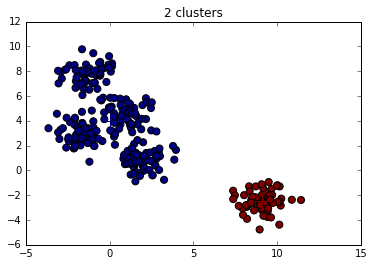

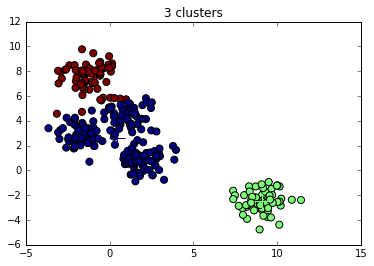

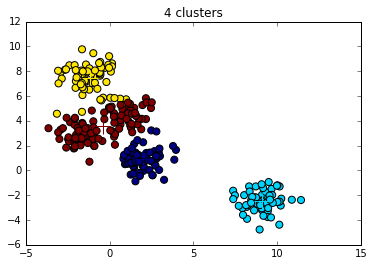

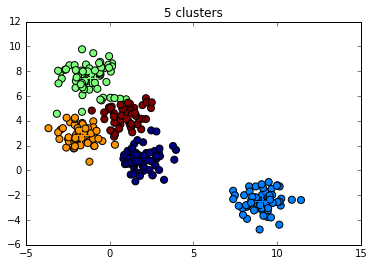

In [11]:
bkm = bikmeans(5, points)

Print SSE

In [12]:
print("SSE of clustering: ", bkm['sse'])

SSE of clustering:  304.7968012182583


Perform regular K-means clustering and compute SSE

In [13]:
km = kmeans(5, points)
print("SSE of clustering: ", km['sse'])

SSE of clustering:  378.6012480345031


Visualize the initial data points with the 'true' clusters

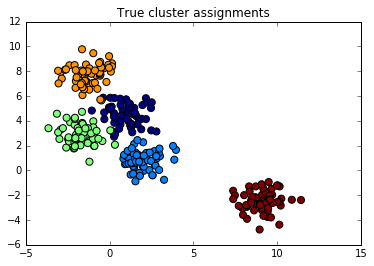

In [14]:
plt.clf()
plt.scatter([x[0] for x in points], [x[1] for x in points], c=clusters, marker='o', s=50)
plt.title('True cluster assignments')
plt.show()

Compute the SSE for the 'true' clusters

In [15]:
centroids = get_centroids(points, clusters)
print("SSE of 'true' clustering: ", sum(sse(points, clusters, centroids)))

SSE of 'true' clustering:  296.83547972599746
